In [4]:
import csv
import os
import pymc as pm
from pymc import do, observe
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc

# Create model with no observed data

In [2]:
with pm.Model() as model:

    temp_mw = pm.Dirichlet("temp_mixture_weights", np.array([1]*3))
    temp_prior = pm.Normal("temp_prior", 0, 1, shape=(1,3))
    temp_std = pm.HalfNormal("temp_std", 1, shape=3)
    temp_posterior = pm.NormalMixture(
        "temp_posterior", 
        temp_mw, 
        temp_prior, 
        temp_std
    )
    precip_prior = pm.HalfNormal("precip_prior", 1)
    precip_posterior = pm.Exponential("precip_posterior", precip_prior)
    drought_coefs = pm.Normal("drought_coefs", 0, 1, shape=(4,))
    drought_likelihood_coefs = pm.Deterministic(
        "drought_likelihood_coefs", 
        pt.transpose(
            pm.math.stack(
                [
                     (drought_coefs[0] * temp_posterior) + (drought_coefs[2] * precip_posterior), 
                     (drought_coefs[1] * np.ones(1)) + (drought_coefs[3] * np.ones(1))
                ]
            )
        )
    )
    drought_prior = pm.Deterministic("drought_prior", pm.math.softmax(drought_likelihood_coefs, axis=-1))
    drought_posterior = pm.Categorical("drought_posterior", drought_prior)
    temp_tfp_coef = pm.Normal('temp_tfp_coef',0,10)
    temp_tfp_coef2 = pm.Normal('temp_tfp_coef2',0,10)
    precip_tfp_coef = pm.Normal("precip_tfp_coef",0,10)
    precip_tfp_coef2 = pm.Normal("precip_tfp_coef2",0,10)
    drought_tfp_coef = pm.Normal('drought_tfp_coef',0,10)
    tfp_intercept = pm.Normal('tfp_intercept',0,10)
    tfp_prior = pm.Deterministic(
        "tfp_prior",
        tfp_intercept +
        (temp_tfp_coef * temp_posterior) +
        (temp_tfp_coef2 * pt.sqr(temp_posterior)) +
        (precip_tfp_coef * precip_posterior) +
        (precip_tfp_coef2 * pt.sqr(precip_posterior)) +
        (drought_tfp_coef * drought_posterior)
    )
    tfp_std = pm.HalfNormal('tfp_std', sigma=10)
    tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std)

In [3]:
set_values = {
    "temp_mixture_weights" : [1,1,1],
    "temp_prior" : [[0,0,0]],
    "temp_std" : [1,1,1],
    "precip_prior" : 1,
    "drought_coefs" : [0,0,0,0],
    "temp_tfp_coef" : 0,
    "temp_tfp_coef2" : 0,
    "precip_tfp_coef" : 0,
    "precip_tfp_coef2" : 0,
    "drought_tfp_coef" : -10,
    "tfp_intercept" : 0
}
model_simulate = do(model, set_values)

In [85]:
with model_simulate:
    simulate = pm.sample_prior_predictive(10000)
    observed = {
        "temp": simulate.prior["temp_posterior"].values.flatten(),
        "precip": simulate.prior["precip_posterior"].values.flatten(),
        "drought": simulate.prior["drought_posterior"].values.flatten(),
        "tfp": simulate.prior["tfp_posterior"].values.flatten()
    }
    df = pd.DataFrame(observed).sort_values("temp", ascending=False)

Sampling: [drought_posterior, precip_posterior, temp_posterior, tfp_posterior, tfp_std]


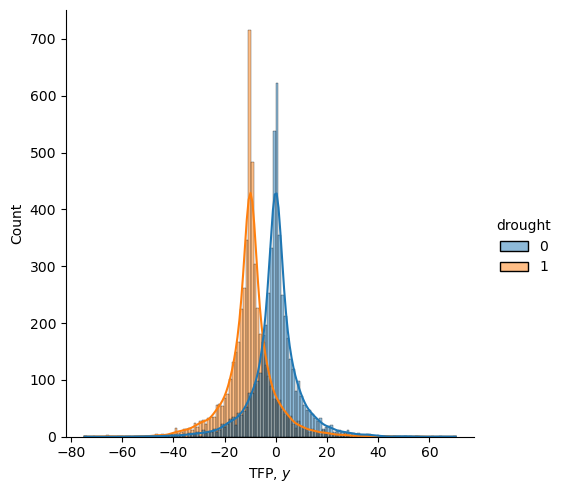

In [86]:
ax = sns.displot(data=df, x="tfp", hue="drought", kde=True)
ax.set(xlabel="TFP, $y$");

In [87]:
with pm.Model() as model:

    temp_mw = pm.Dirichlet("temp_mixture_weights", np.array([1]*3))
    temp_prior = pm.Normal("temp_prior", 0, 1, shape=(1,3))
    temp_std = pm.HalfNormal("temp_std", 1, shape=3)
    temp_posterior = pm.NormalMixture(
        "temp_posterior", 
        temp_mw, 
        temp_prior, 
        temp_std,
        observed=df["temp"]
    )
    precip_prior = pm.HalfNormal("precip_prior", 1)
    precip_posterior = pm.Exponential("precip_posterior", precip_prior, observed=df["precip"])
    drought_coefs = pm.Normal("drought_coefs", 0, 1, shape=(4,))
    drought_likelihood_coefs = pm.Deterministic(
        "drought_likelihood_coefs", 
        pt.transpose(
            pm.math.stack(
                [
                     (drought_coefs[0] * temp_posterior) + (drought_coefs[2] * precip_posterior), 
                     (drought_coefs[1] * np.ones(len(df["temp"]))) + (drought_coefs[3] * np.ones(len(df["temp"])))
                ]
            )
        )
    )
    drought_prior = pm.Deterministic("drought_prior", pm.math.softmax(drought_likelihood_coefs, axis=-1))
    drought_posterior = pm.Categorical("drought_posterior", drought_prior, observed=df["drought"])
    temp_tfp_coef = pm.Normal('temp_tfp_coef',0,10)
    temp_tfp_coef2 = pm.Normal('temp_tfp_coef2',0,10)
    precip_tfp_coef = pm.Normal("precip_tfp_coef",0,10)
    precip_tfp_coef2 = pm.Normal("precip_tfp_coef2",0,10)
    drought_tfp_coef = pm.Normal('drought_tfp_coef',0,10)
    tfp_intercept = pm.Normal('tfp_intercept',0,10)
    tfp_prior = pm.Deterministic(
        "tfp_prior",
        tfp_intercept +
        (temp_tfp_coef * temp_posterior) +
        (temp_tfp_coef2 * pt.sqr(temp_posterior)) +
        (precip_tfp_coef * precip_posterior) +
        (precip_tfp_coef2 * pt.sqr(precip_posterior)) +
        (drought_tfp_coef * drought_posterior)
    )
    tfp_std = pm.HalfNormal('tfp_std', sigma=10)
    tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std, observed=df["tfp"])

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temp_mixture_weights, temp_prior, temp_std, precip_prior, drought_coefs, temp_tfp_coef, temp_tfp_coef2, precip_tfp_coef, precip_tfp_coef2, drought_tfp_coef, tfp_intercept, tfp_std]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 1394 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


# Parameter recovery to check model validity

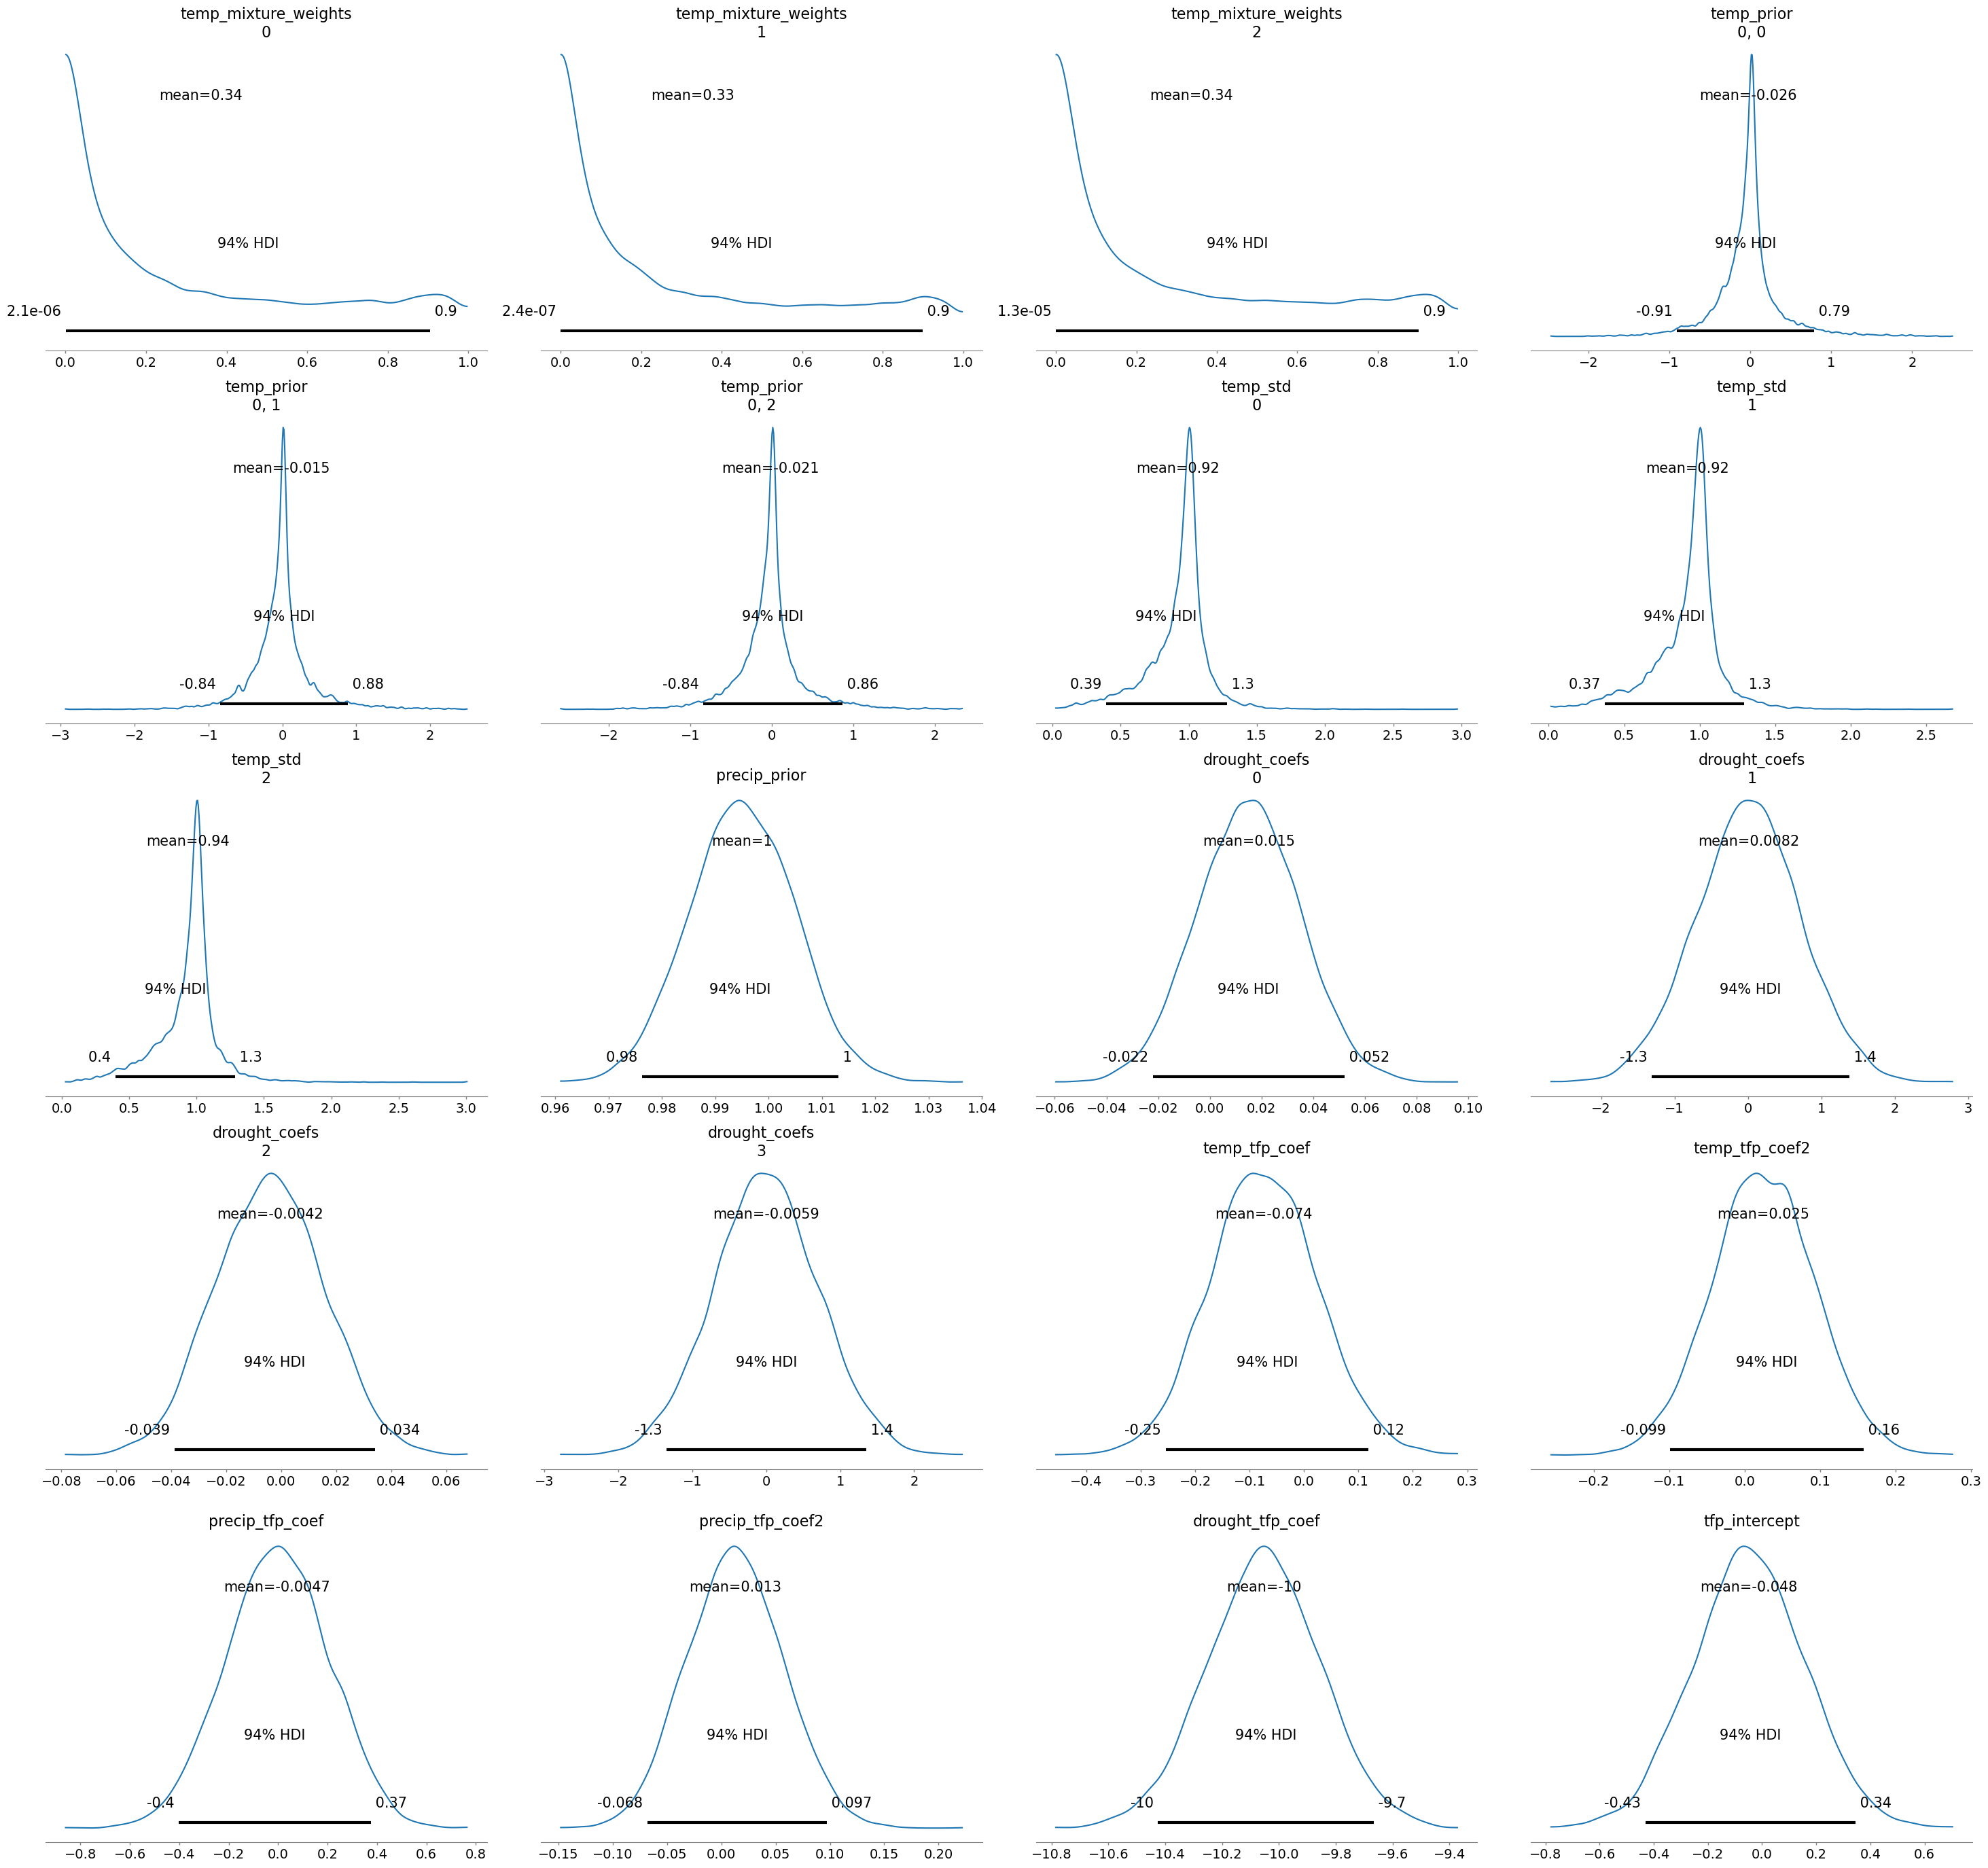

In [88]:
keys = list(set_values.keys())
az.plot_posterior(
    idata,
    var_names=keys,
)
plt.tight_layout();

# Regional Effect of Drought on TFP

## How much does drought effect tfp in each region? (Average Treatment Effect)

In [2]:
integrated_data = pd.read_csv("../data/processed/five_node_model_integrated_data.csv")
countries_by_region = {}
data_by_country = {}
data_by_region = {}
for country in set(integrated_data["Country"]):
    region = cc.convert(country, to="UNregion")
    if region not in countries_by_region:
        countries_by_region[region] = []
    countries_by_region[region].append(country)
for region, countries in countries_by_region.items():
    regional_data = integrated_data.loc[(integrated_data["Country"].isin(countries))]
    data_by_region[region] = regional_data
    for country in countries:
        data_by_country[country] = integrated_data.loc[(integrated_data["Country"]==country)]

Eastern Europe


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in temp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17FD94AC0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17FDE3760>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior_observed, tfp_posterior]


Estimated ATE for Eastern Europe = -0.74


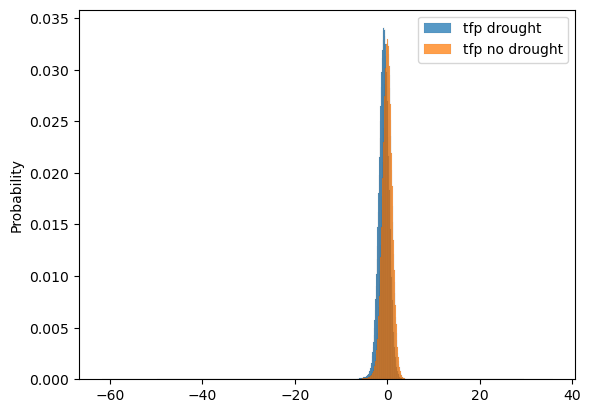

Melanesia


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Estimated ATE for Melanesia = -0.68


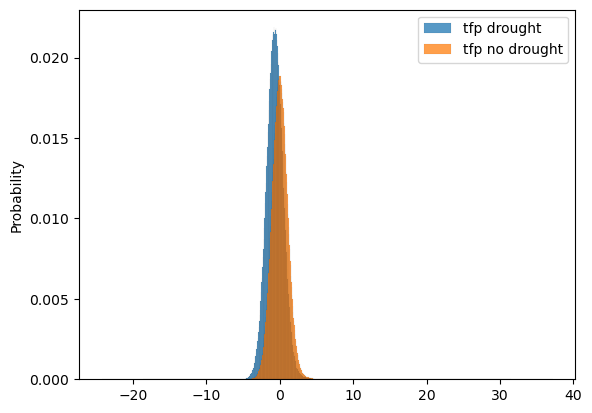

South-eastern Asia


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Estimated ATE for South-eastern Asia = -0.17


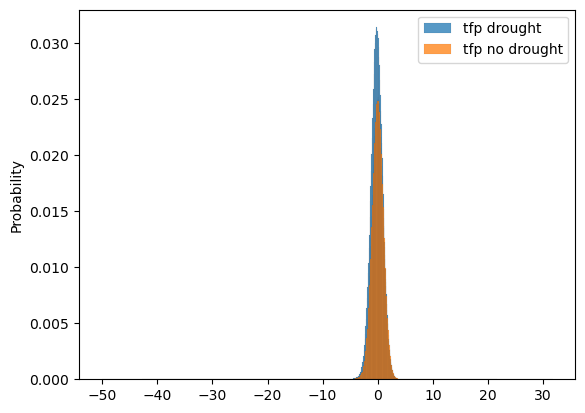

Middle Africa


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in temp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x11EF9DC40>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x11EF565E0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior_observed, tfp_posterior]


Estimated ATE for Middle Africa = 0.26


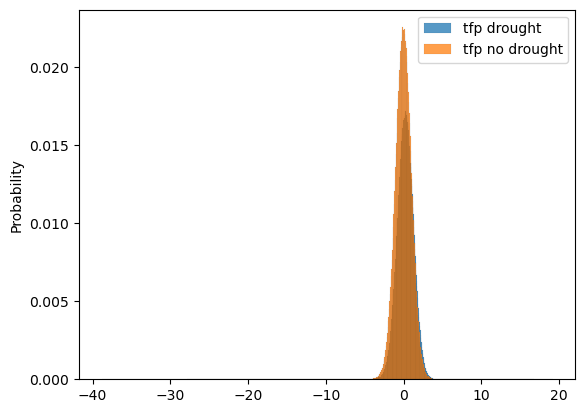

South America


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Estimated ATE for South America = 0.04


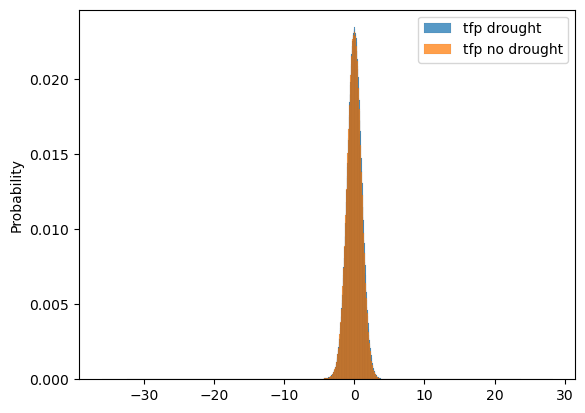

Central America


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Estimated ATE for Central America = 0.07


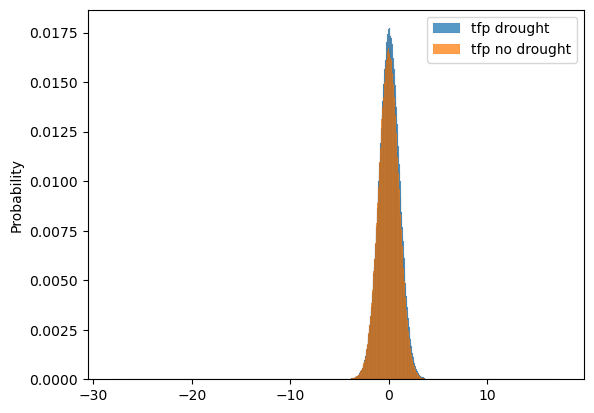

Northern Africa


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Estimated ATE for Northern Africa = -0.20


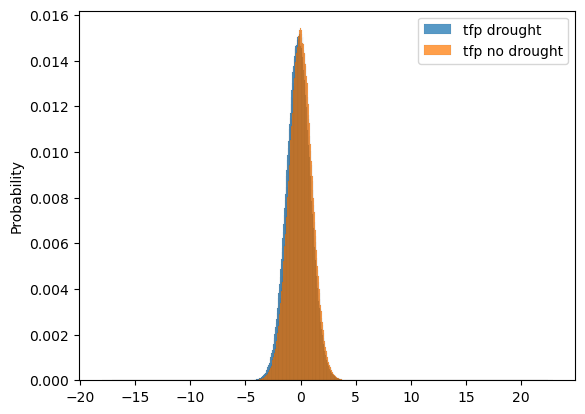

Southern Africa


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Estimated ATE for Southern Africa = 0.31


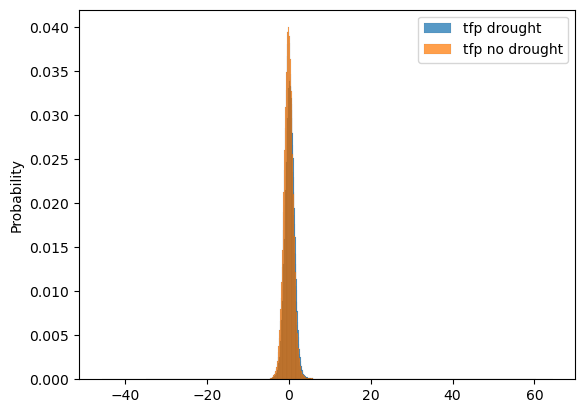

Western Africa


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Estimated ATE for Western Africa = -0.15


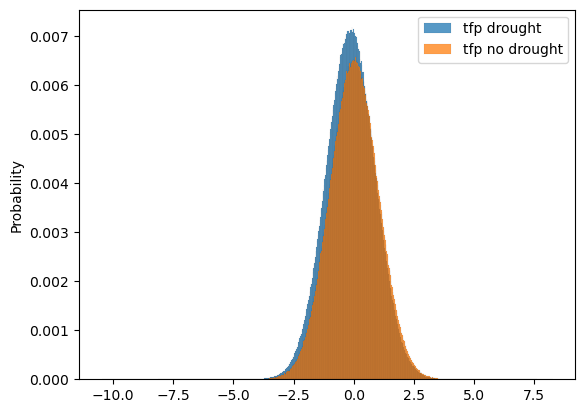

Eastern Africa


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in temp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x176CCCF20>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x119194200>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior_observed, tfp_posterior]


Estimated ATE for Eastern Africa = -0.12


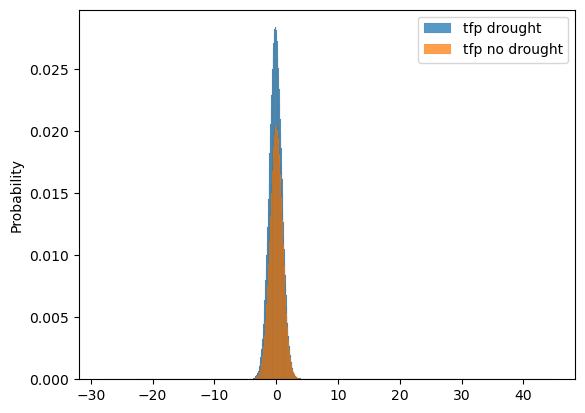

Caribbean


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Estimated ATE for Caribbean = -0.30


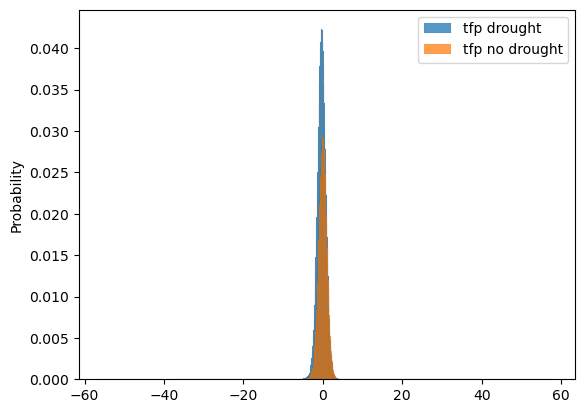

Central Asia


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Estimated ATE for Central Asia = -0.23


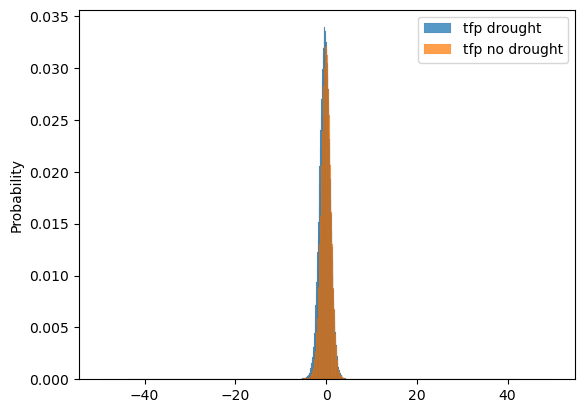

Southern Asia


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Estimated ATE for Southern Asia = -0.68


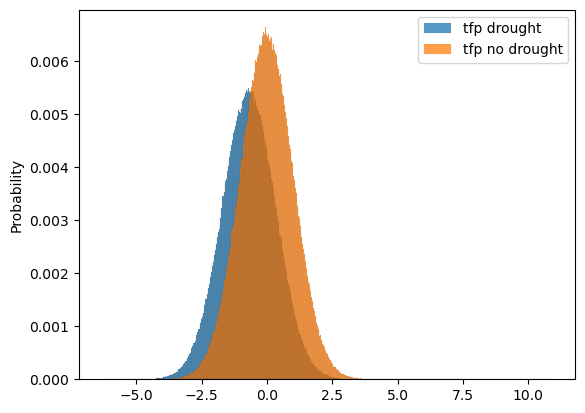

Western Asia


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x11BB8D620>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x118866420>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior, tfp_posterior]


Estimated ATE for Western Asia = -0.13


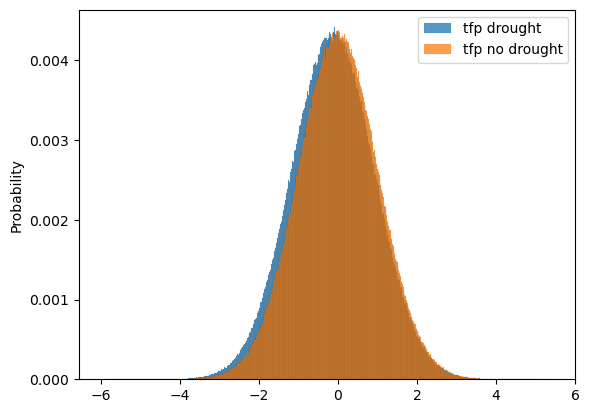

Eastern Asia


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Estimated ATE for Eastern Asia = 0.14


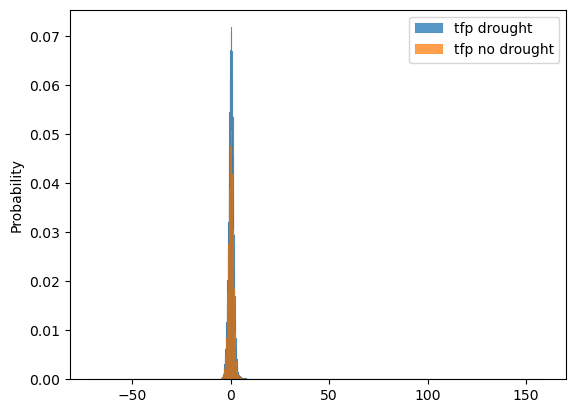

Northern Europe


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2849897E0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x11EBB11C0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [precip_posterior_observed, temp_posterior, tfp_posterior]


Estimated ATE for Northern Europe = -1.60


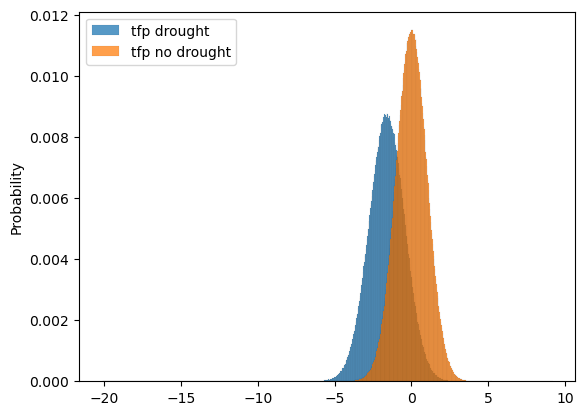

Southern Europe


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Estimated ATE for Southern Europe = -0.35


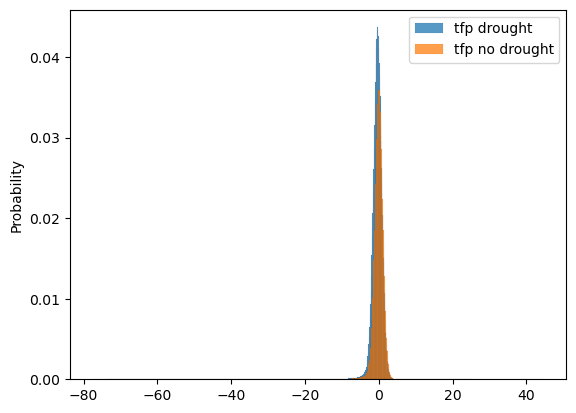

Northern America


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Estimated ATE for Northern America = -0.22


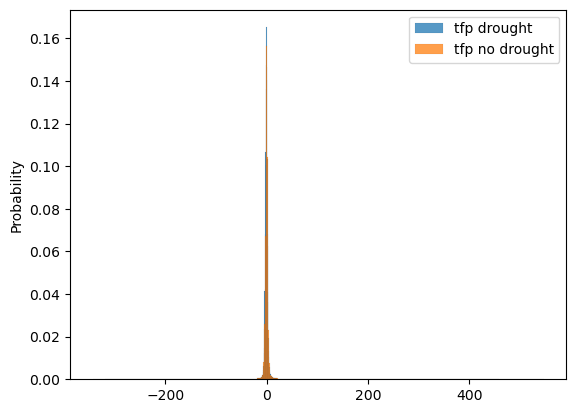

Western Europe


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Estimated ATE for Western Europe = -0.11


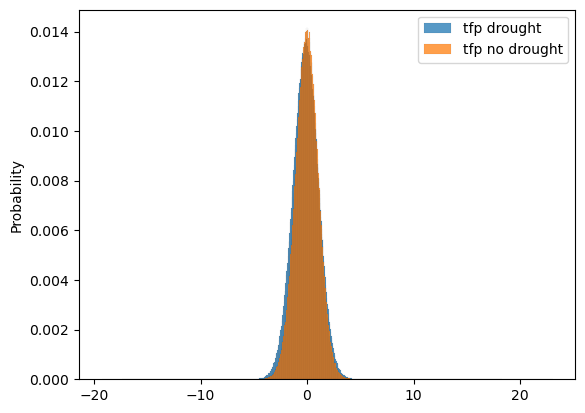

Australia and New Zealand


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Sampling: [precip_posterior, temp_posterior, tfp_posterior]


Estimated ATE for Australia and New Zealand = 0.00


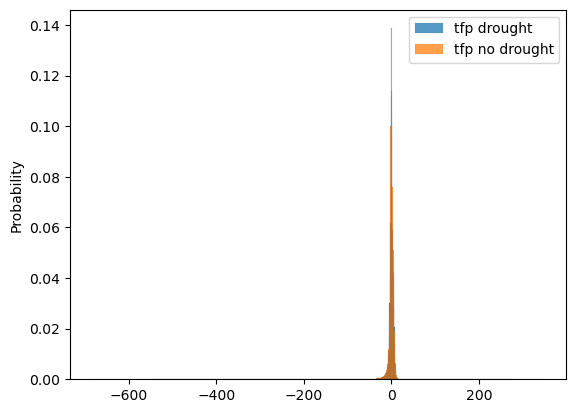

In [9]:
for region, data in data_by_region.items():
    print(region)

    # Normalize data
    temp_scaler, precip_scaler, tfp_scaler = StandardScaler(), MinMaxScaler(), StandardScaler()
    normalized_temp = temp_scaler.fit_transform(np.array(data["Unweighted_Temp"]).reshape(-1,1)).flatten()
    normalized_precip = precip_scaler.fit_transform(np.array(data["Precipitation"]).reshape(-1,1)).flatten()
    normalized_tfp = tfp_scaler.fit_transform(np.array(data["ln_TFP_Change"]).reshape(-1,1)).flatten()
    
    with pm.Model() as model:
    
        temp_mw = pm.Dirichlet("temp_mixture_weights", np.array([1]*3))
        temp_prior = pm.Normal("temp_prior", 0, 1, shape=(1,3))
        temp_std = pm.HalfNormal("temp_std", 1, shape=3)
        temp_posterior = pm.NormalMixture(
            "temp_posterior", 
            temp_mw, 
            temp_prior, 
            temp_std,
            observed=normalized_temp
        )
        precip_prior = pm.HalfNormal("precip_prior", 1)
        precip_posterior = pm.Exponential("precip_posterior", precip_prior, observed=normalized_precip)
        drought_coefs = pm.Normal("drought_coefs", 0, 1, shape=(4,))
        drought_likelihood_coefs = pm.Deterministic(
            "drought_likelihood_coefs", 
            pt.transpose(
                pm.math.stack(
                    [
                         (drought_coefs[0] * temp_posterior) + (drought_coefs[2] * precip_posterior), 
                         (drought_coefs[1] * np.ones(len(normalized_temp))) + (drought_coefs[3] * np.ones(len(normalized_temp)))
                    ]
                )
            )
        )
        drought_prior = pm.Deterministic("drought_prior", pm.math.softmax(drought_likelihood_coefs, axis=-1))
        drought_posterior = pm.Categorical("drought_posterior", drought_prior)
        temp_tfp_coef = pm.Normal('temp_tfp_coef',0,10)
        temp_tfp_coef2 = pm.Normal('temp_tfp_coef2',0,10)
        precip_tfp_coef = pm.Normal("precip_tfp_coef",0,10)
        precip_tfp_coef2 = pm.Normal("precip_tfp_coef2",0,10)
        drought_tfp_coef = pm.Normal('drought_tfp_coef',0,10)
        tfp_intercept = pm.Normal('tfp_intercept',0,10)
        tfp_prior = pm.Deterministic(
            "tfp_prior",
            tfp_intercept +
            (temp_tfp_coef * temp_posterior) +
            (temp_tfp_coef2 * pt.sqr(temp_posterior)) +
            (precip_tfp_coef * precip_posterior) +
            (precip_tfp_coef2 * pt.sqr(precip_posterior)) +
            (drought_tfp_coef * drought_posterior)
        )
        tfp_std = pm.HalfNormal('tfp_std', sigma=10)
        tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std)
    
    no_drought_model = do(model, {"drought_posterior": np.zeros(len(normalized_temp), dtype="int32")})
    drought_model = do(model, {"drought_posterior": np.ones(len(normalized_temp), dtype="int32")})

    # load regional model from pkl
    regional_trace = pd.read_pickle(f"../models/regional_models/temp_precip_drought_tfp_{region}.pkl")["trace"]
    
    no_drought_tfp_samples = pm.sample_posterior_predictive(
        regional_trace,
        model=no_drought_model,
        var_names=["tfp_posterior"]
    )
    drought_tfp_samples = pm.sample_posterior_predictive(
        regional_trace,
        model=drought_model,
        var_names=["tfp_posterior"]
    )
    
    ATE_est = drought_tfp_samples.posterior_predictive - no_drought_tfp_samples.posterior_predictive
    print(f"Estimated ATE for {region} = {ATE_est.tfp_posterior.mean().values:.2f}")
    
    fig, ax = plt.subplots()
    sns.histplot(data=np.array(drought_tfp_samples.posterior_predictive.tfp_posterior).flatten(), stat='probability', bins=1000, ax=ax, label="tfp drought")
    sns.histplot(data=np.array(no_drought_tfp_samples.posterior_predictive.tfp_posterior).flatten(), stat='probability', bins=1000, ax=ax, label="tfp no drought")
    ax.legend()
    plt.show()

# Regional effect of temperature on tfp

Eastern Europe


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17C4457E0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x11CDA8660>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


Estimated ATE for Eastern Europe = -0.01


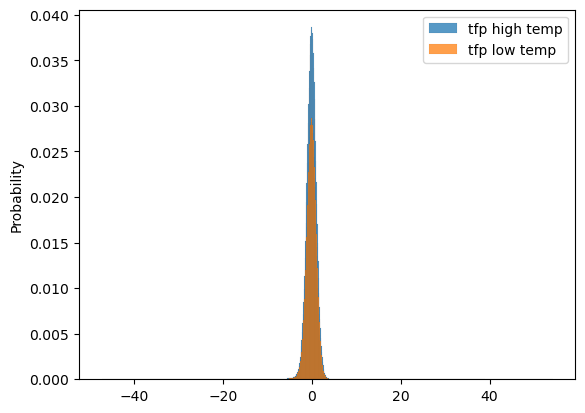

Melanesia


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Estimated ATE for Melanesia = -0.50


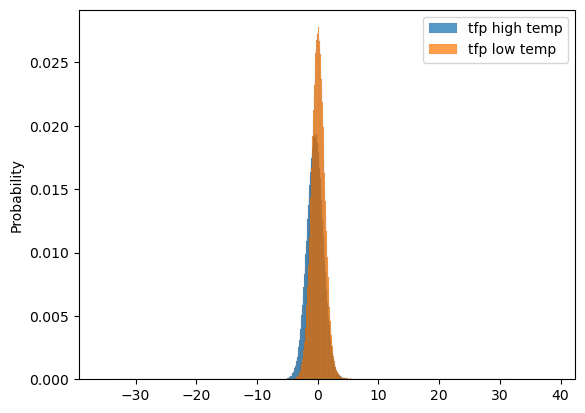

South-eastern Asia


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Estimated ATE for South-eastern Asia = 0.01


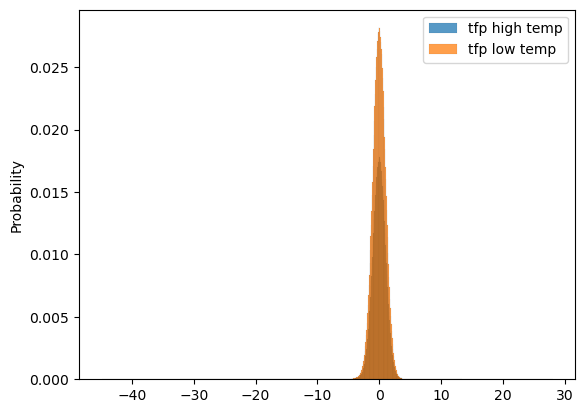

Middle Africa


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1793C3140>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17FDE3E60>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


Estimated ATE for Middle Africa = -0.15


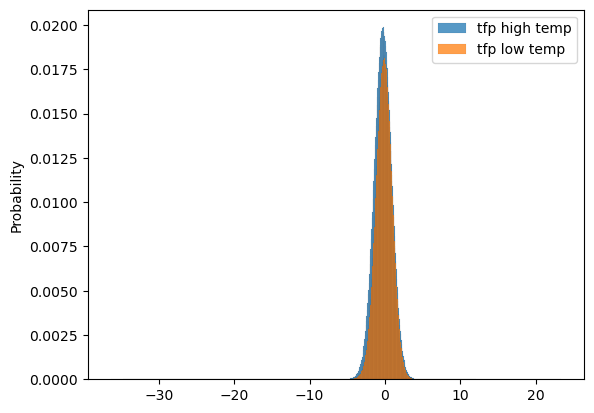

South America


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Estimated ATE for South America = 0.02


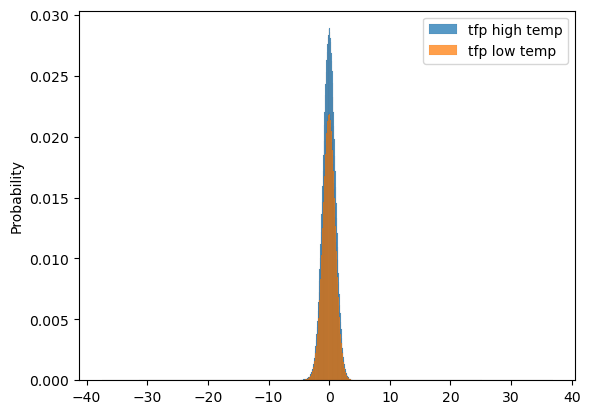

Central America


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Estimated ATE for Central America = -0.18


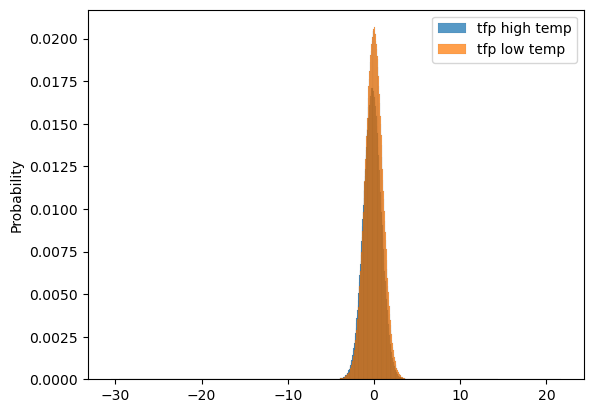

Northern Africa


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Estimated ATE for Northern Africa = 0.00


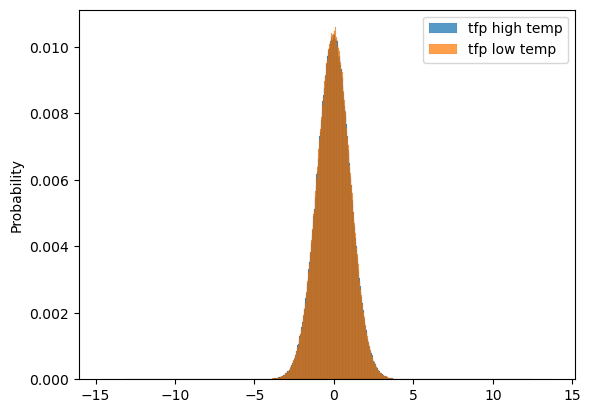

Southern Africa


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Estimated ATE for Southern Africa = 0.09


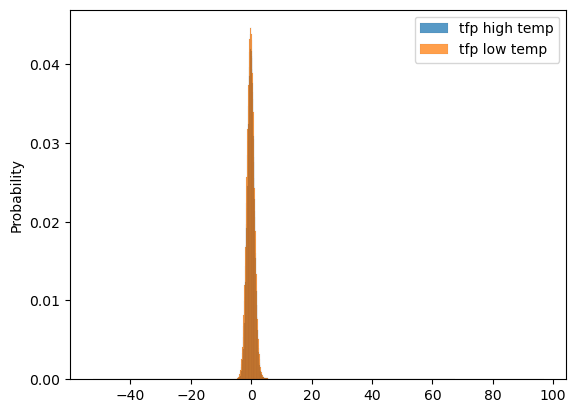

Western Africa


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Estimated ATE for Western Africa = 0.01


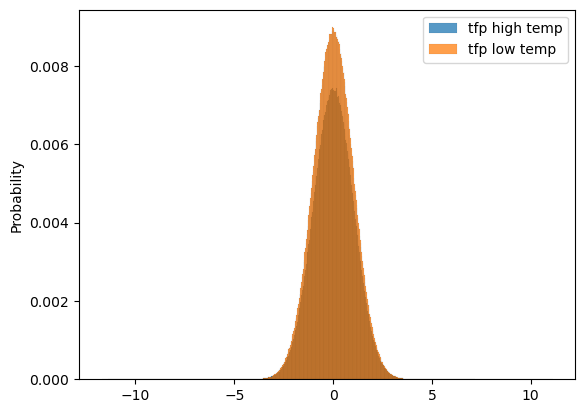

Eastern Africa


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1796FA340>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1796F5380>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


Estimated ATE for Eastern Africa = -0.02


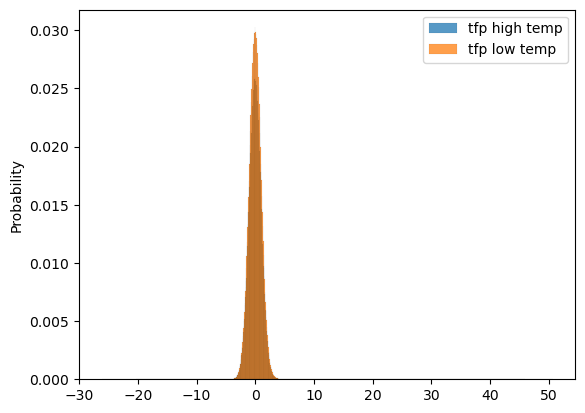

Caribbean


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Estimated ATE for Caribbean = -0.22


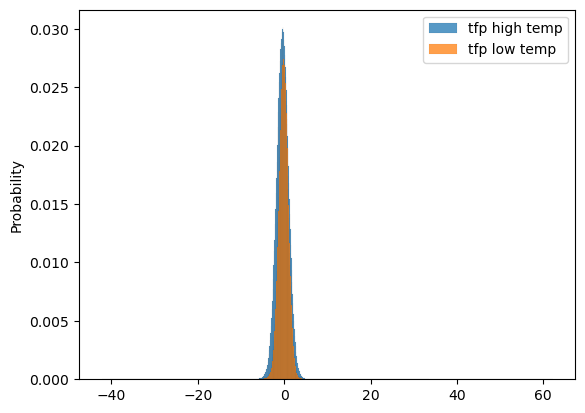

Central Asia


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Estimated ATE for Central Asia = -0.02


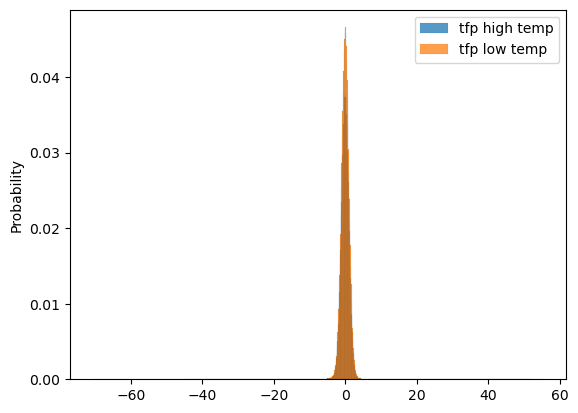

Southern Asia


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Estimated ATE for Southern Asia = 0.00


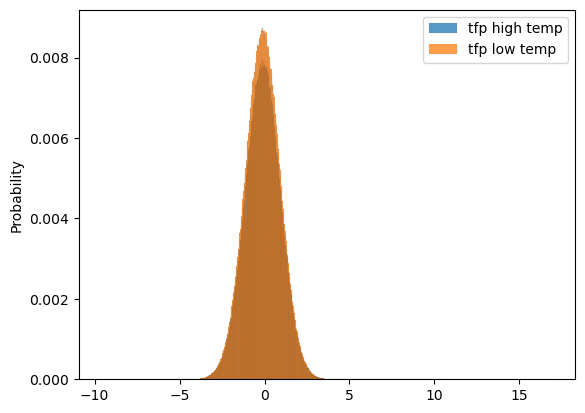

Western Asia


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x119A11D20>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x119A10660>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


Estimated ATE for Western Asia = -0.03


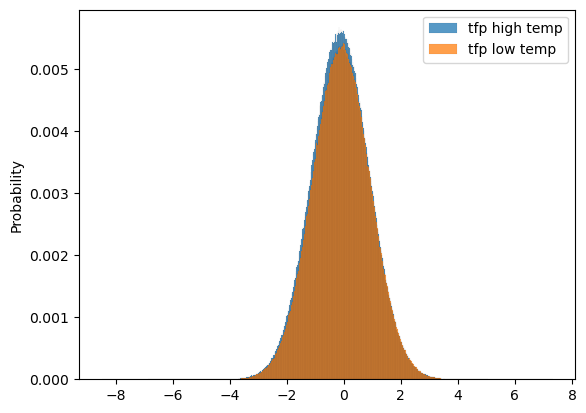

Eastern Asia


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Estimated ATE for Eastern Asia = -0.26


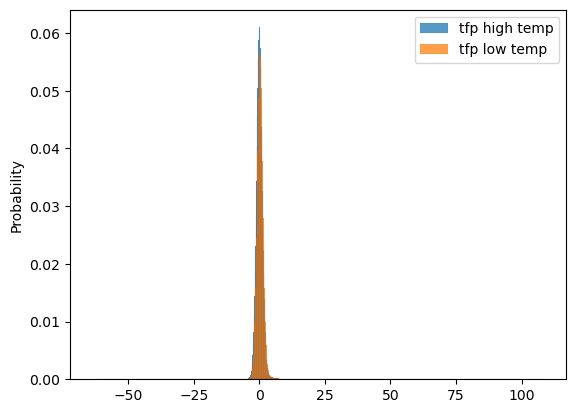

Northern Europe


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x11A55DFC0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x11A55D000>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed, tfp_posterior]


Estimated ATE for Northern Europe = 0.04


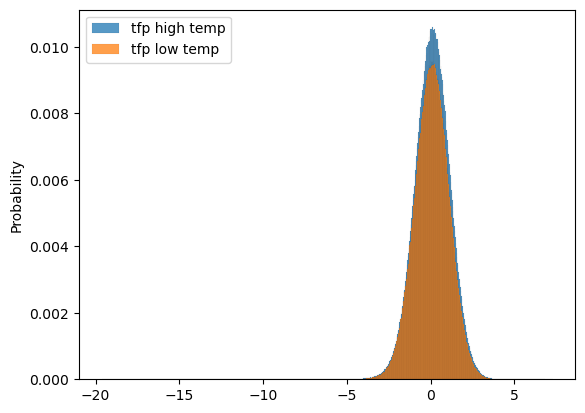

Southern Europe


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Estimated ATE for Southern Europe = 0.18


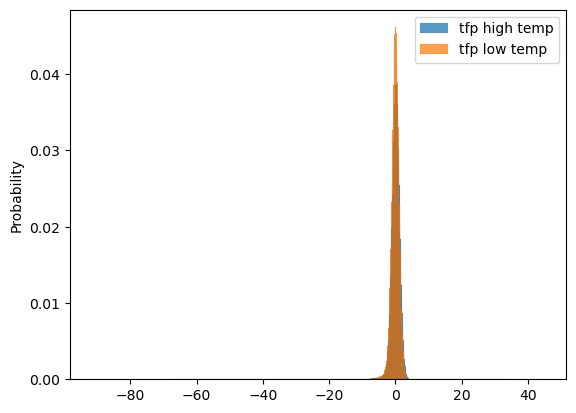

Northern America


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Estimated ATE for Northern America = -0.04


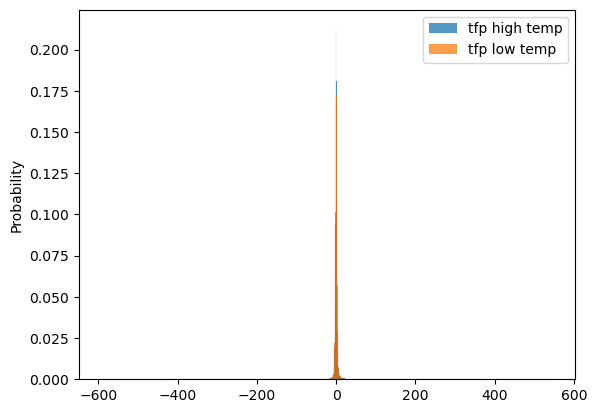

Western Europe


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Estimated ATE for Western Europe = -0.18


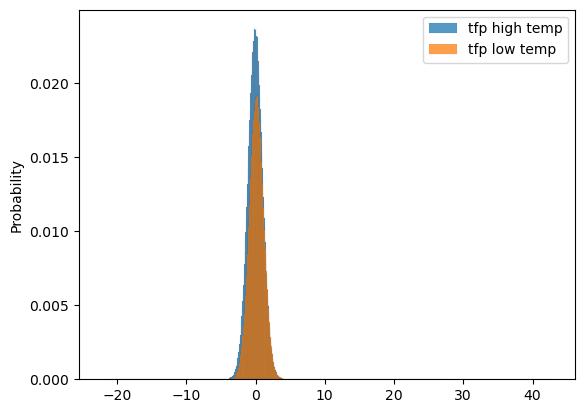

Australia and New Zealand


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Sampling: [drought_posterior, precip_posterior, tfp_posterior]


Estimated ATE for Australia and New Zealand = -0.36


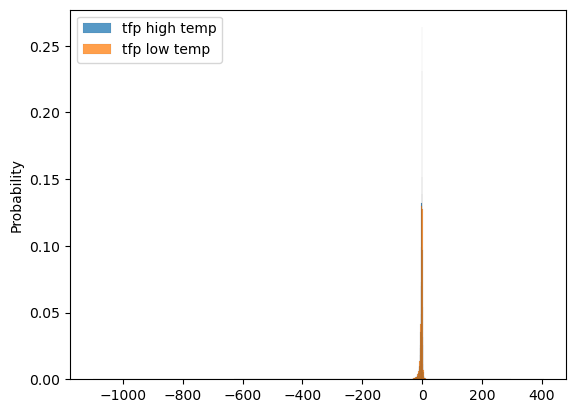

In [42]:
for region, data in data_by_region.items():
    print(region)

    # Normalize data
    temp_scaler, precip_scaler, tfp_scaler = StandardScaler(), MinMaxScaler(), StandardScaler()
    normalized_temp = temp_scaler.fit_transform(np.array(data["Unweighted_Temp"]).reshape(-1,1)).flatten()
    normalized_precip = precip_scaler.fit_transform(np.array(data["Precipitation"]).reshape(-1,1)).flatten()
    normalized_tfp = tfp_scaler.fit_transform(np.array(data["ln_TFP_Change"]).reshape(-1,1)).flatten()
    
    with pm.Model() as model:
    
        temp_mw = pm.Dirichlet("temp_mixture_weights", np.array([1]*3))
        temp_prior = pm.Normal("temp_prior", 0, 1, shape=(1,3))
        temp_std = pm.HalfNormal("temp_std", 1, shape=3)
        temp_posterior = pm.NormalMixture(
            "temp_posterior", 
            temp_mw, 
            temp_prior, 
            temp_std
        )
        precip_prior = pm.HalfNormal("precip_prior", 1)
        precip_posterior = pm.Exponential("precip_posterior", precip_prior, observed=normalized_precip)
        drought_coefs = pm.Normal("drought_coefs", 0, 1, shape=(4,))
        drought_likelihood_coefs = pm.Deterministic(
            "drought_likelihood_coefs", 
            pt.transpose(
                pm.math.stack(
                    [
                         (drought_coefs[0] * temp_posterior) + (drought_coefs[2] * precip_posterior), 
                         (drought_coefs[1] * np.ones(len(normalized_temp))) + (drought_coefs[3] * np.ones(len(normalized_temp)))
                    ]
                )
            )
        )
        drought_prior = pm.Deterministic("drought_prior", pm.math.softmax(drought_likelihood_coefs, axis=-1))
        drought_posterior = pm.Categorical("drought_posterior", drought_prior, observed=data["Drought"])
        temp_tfp_coef = pm.Normal('temp_tfp_coef',0,10)
        temp_tfp_coef2 = pm.Normal('temp_tfp_coef2',0,10)
        precip_tfp_coef = pm.Normal("precip_tfp_coef",0,10)
        precip_tfp_coef2 = pm.Normal("precip_tfp_coef2",0,10)
        drought_tfp_coef = pm.Normal('drought_tfp_coef',0,10)
        tfp_intercept = pm.Normal('tfp_intercept',0,10)
        tfp_prior = pm.Deterministic(
            "tfp_prior",
            tfp_intercept +
            (temp_tfp_coef * temp_posterior) +
            (temp_tfp_coef2 * pt.sqr(temp_posterior)) +
            (precip_tfp_coef * precip_posterior) +
            (precip_tfp_coef2 * pt.sqr(precip_posterior)) +
            (drought_tfp_coef * drought_posterior)
        )
        tfp_std = pm.HalfNormal('tfp_std', sigma=10)
        tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std)

    # load regional model from pkl
    regional_model = pd.read_pickle(f"../models/regional_models/temp_precip_drought_tfp_{region}.pkl")
    regional_trace = regional_model["trace"]
    # TODO: Fix this, it is not taking the mean 2016 temp of all countries in the region
    mean_temp = [val for val in np.array(data["Unweighted_Temp"]) if not np.isnan(val)][-1]
    mean_temp_data = np.zeros(len(normalized_temp)) + mean_temp
    mean_temp_scaled = temp_scaler.transform(mean_temp_data.reshape(-1,1)).flatten()
    mean_temp_scaled_temp_increase = temp_scaler.transform(np.array([mean_temp + 1.5 for i in range(len(normalized_temp))]).reshape(-1,1)).flatten()

    high_temp_model = do(model, {"temp_posterior": mean_temp_scaled_temp_increase})
    low_temp_model = do(model, {"temp_posterior": mean_temp_scaled})
    
    high_temp_tfp_samples = pm.sample_posterior_predictive(
        regional_trace,
        model=high_temp_model,
        var_names=["tfp_posterior"]
    )
    low_temp_tfp_samples = pm.sample_posterior_predictive(
        regional_trace,
        model=low_temp_model,
        var_names=["tfp_posterior"]
    )
    
    ATE_est = high_temp_tfp_samples.posterior_predictive - low_temp_tfp_samples.posterior_predictive
    print(f"Estimated ATE for {region} = {ATE_est.tfp_posterior.mean().values:.2f}")
    
    fig, ax = plt.subplots()
    sns.histplot(data=np.array(high_temp_tfp_samples.posterior_predictive.tfp_posterior).flatten(), stat='probability', bins=1000, ax=ax, label="tfp high temp")
    sns.histplot(data=np.array(low_temp_tfp_samples.posterior_predictive.tfp_posterior).flatten(), stat='probability', bins=1000, ax=ax, label="tfp low temp")
    ax.legend()
    plt.show()

# Regional effect of temperature on drought

Eastern Europe


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17CD219A0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17CD21FC0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed]


Estimated ATE for Eastern Europe = -0.00


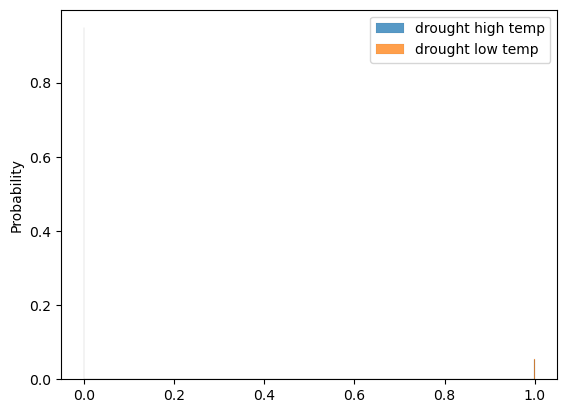

Melanesia


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Melanesia = 0.02


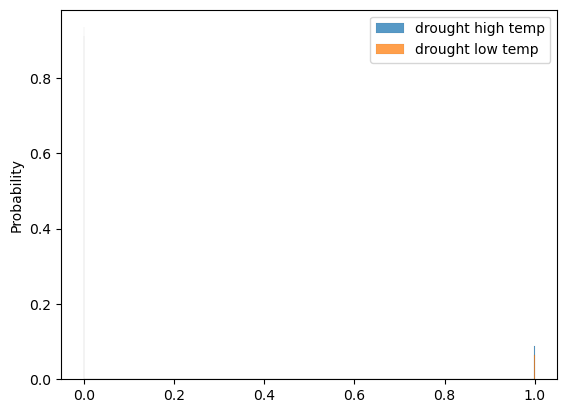

South-eastern Asia


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for South-eastern Asia = 0.01


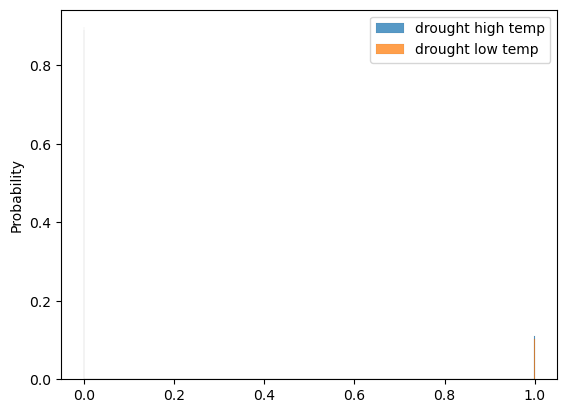

Middle Africa


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1197790E0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17BDC59A0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed]


Estimated ATE for Middle Africa = 0.01


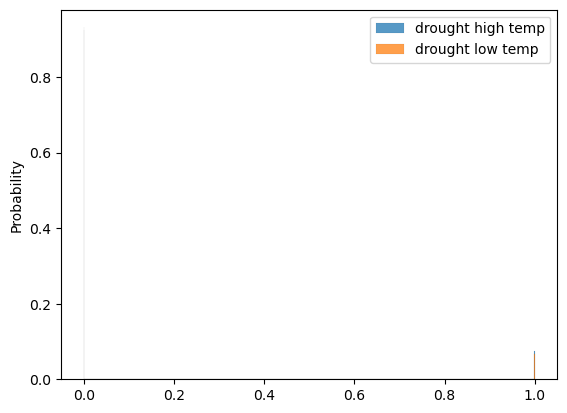

South America


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for South America = 0.02


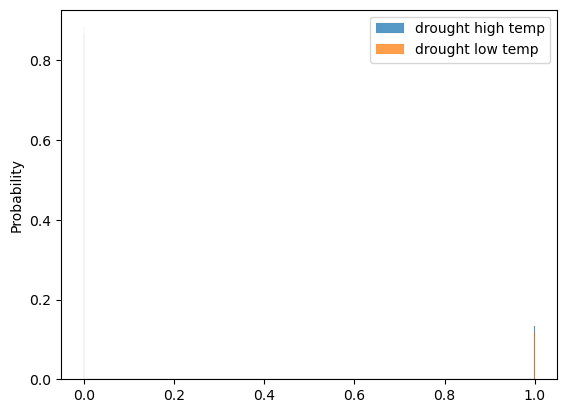

Central America


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Central America = 0.01


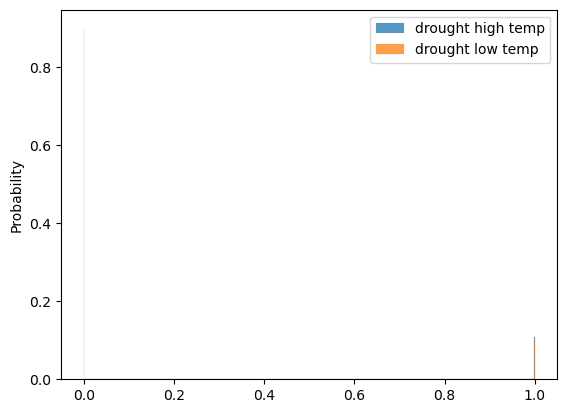

Northern Africa


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Northern Africa = -0.01


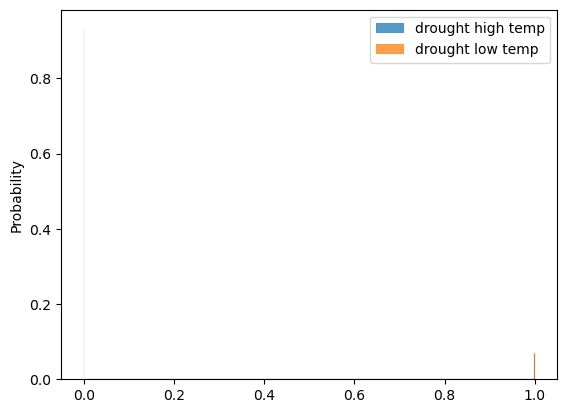

Southern Africa


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Southern Africa = 0.00


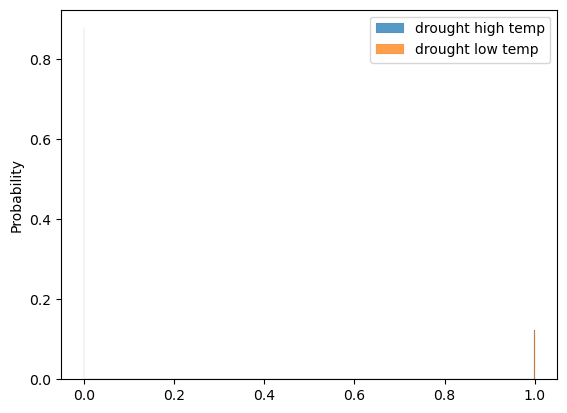

Western Africa


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Western Africa = 0.07


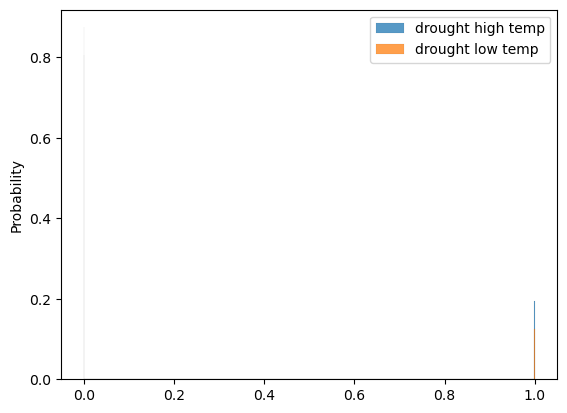

Eastern Africa


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17BEA98C0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17BEA84A0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed]


Estimated ATE for Eastern Africa = 0.02


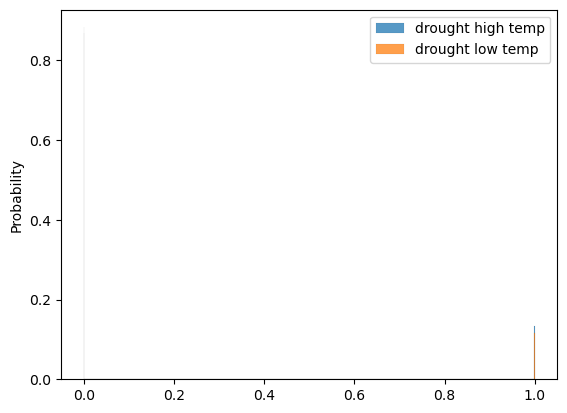

Caribbean


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Caribbean = 0.06


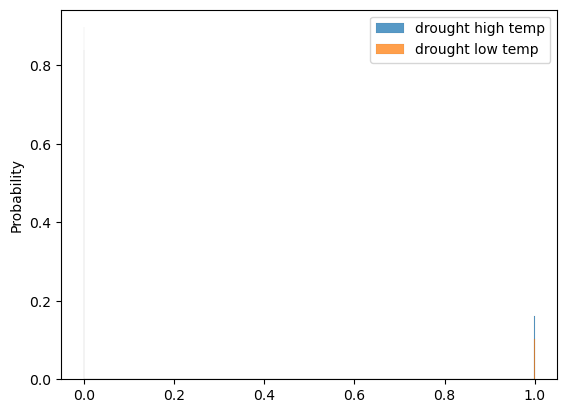

Central Asia


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Central Asia = -0.00


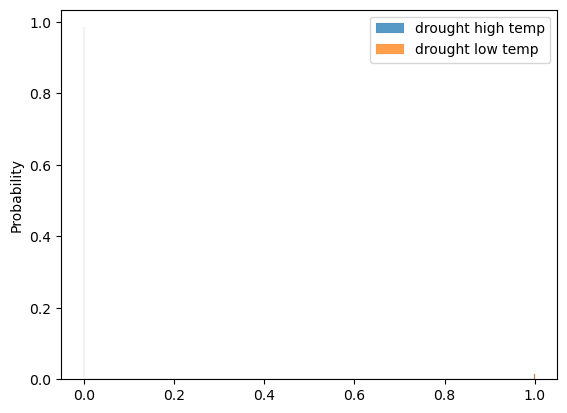

Southern Asia


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Southern Asia = 0.01


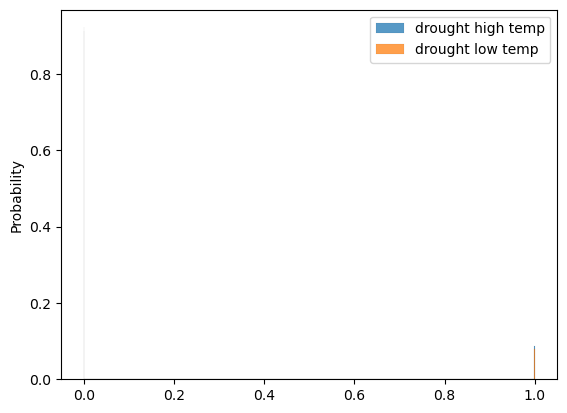

Western Asia


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17E2C2420>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17E6E7CA0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed]


Estimated ATE for Western Asia = -0.00


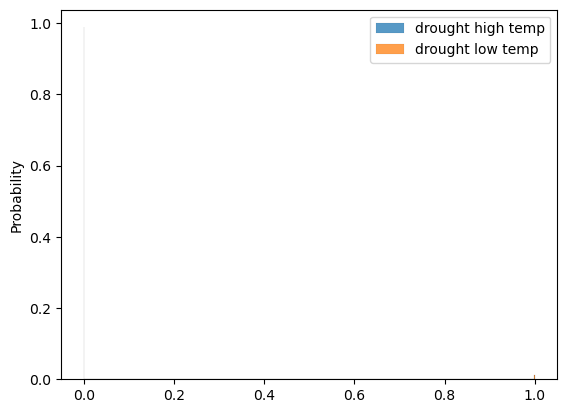

Eastern Asia


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Eastern Asia = -0.01


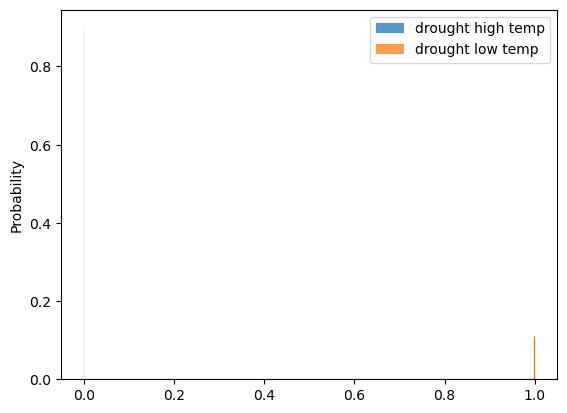

Northern Europe


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1795C5E00>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed]


/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pymc/pytensorf.py:850: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x11980BA00>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, precip_posterior_observed]


Estimated ATE for Northern Europe = 0.00


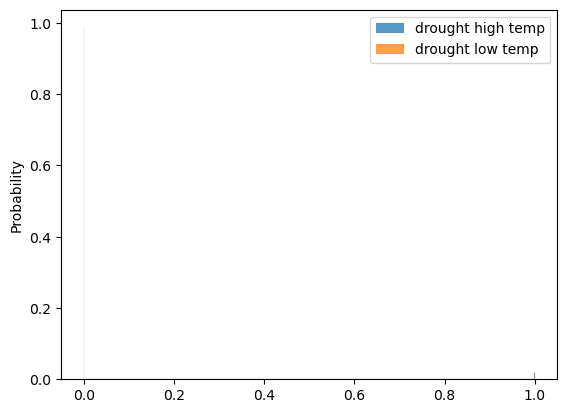

Southern Europe


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Southern Europe = 0.03


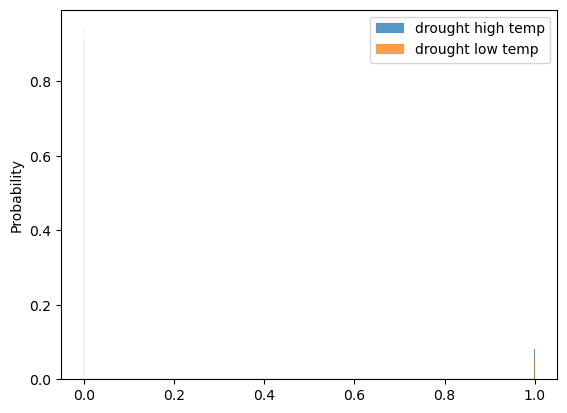

Northern America


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Northern America = 0.01


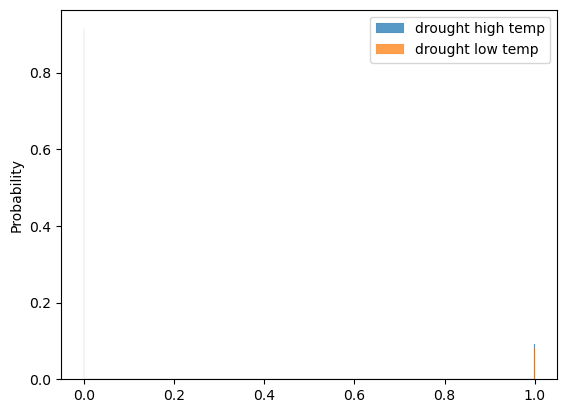

Western Europe


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Western Europe = 0.04


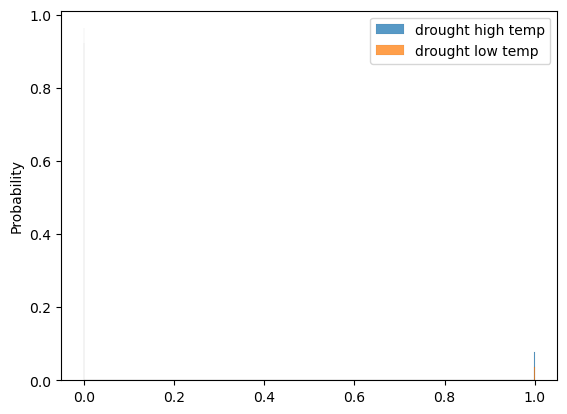

Australia and New Zealand


Sampling: [drought_posterior, precip_posterior]


Sampling: [drought_posterior, precip_posterior]


Estimated ATE for Australia and New Zealand = 0.01


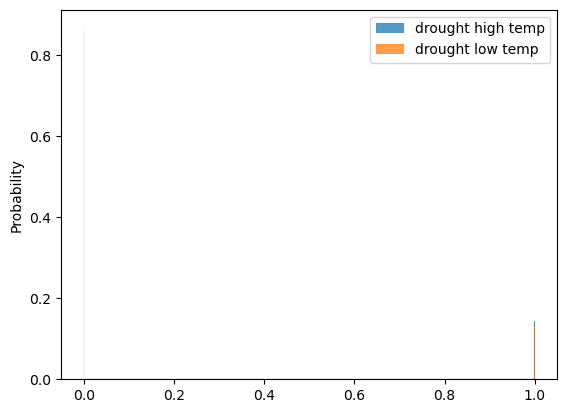

In [44]:
for region, data in data_by_region.items():
    print(region)

    # Normalize data
    temp_scaler, precip_scaler, tfp_scaler = StandardScaler(), MinMaxScaler(), StandardScaler()
    normalized_temp = temp_scaler.fit_transform(np.array(data["Unweighted_Temp"]).reshape(-1,1)).flatten()
    normalized_precip = precip_scaler.fit_transform(np.array(data["Precipitation"]).reshape(-1,1)).flatten()
    normalized_tfp = tfp_scaler.fit_transform(np.array(data["ln_TFP_Change"]).reshape(-1,1)).flatten()
    
    with pm.Model() as model:
    
        temp_mw = pm.Dirichlet("temp_mixture_weights", np.array([1]*3))
        temp_prior = pm.Normal("temp_prior", 0, 1, shape=(1,3))
        temp_std = pm.HalfNormal("temp_std", 1, shape=3)
        temp_posterior = pm.NormalMixture(
            "temp_posterior", 
            temp_mw, 
            temp_prior, 
            temp_std
        )
        precip_prior = pm.HalfNormal("precip_prior", 1)
        precip_posterior = pm.Exponential("precip_posterior", precip_prior, observed=normalized_precip)
        drought_coefs = pm.Normal("drought_coefs", 0, 1, shape=(4,))
        drought_likelihood_coefs = pm.Deterministic(
            "drought_likelihood_coefs", 
            pt.transpose(
                pm.math.stack(
                    [
                         (drought_coefs[0] * temp_posterior) + (drought_coefs[2] * precip_posterior), 
                         (drought_coefs[1] * np.ones(len(normalized_temp))) + (drought_coefs[3] * np.ones(len(normalized_temp)))
                    ]
                )
            )
        )
        drought_prior = pm.Deterministic("drought_prior", pm.math.softmax(drought_likelihood_coefs, axis=-1))
        drought_posterior = pm.Categorical("drought_posterior", drought_prior, observed=data["Drought"])
        temp_tfp_coef = pm.Normal('temp_tfp_coef',0,10)
        temp_tfp_coef2 = pm.Normal('temp_tfp_coef2',0,10)
        precip_tfp_coef = pm.Normal("precip_tfp_coef",0,10)
        precip_tfp_coef2 = pm.Normal("precip_tfp_coef2",0,10)
        drought_tfp_coef = pm.Normal('drought_tfp_coef',0,10)
        tfp_intercept = pm.Normal('tfp_intercept',0,10)
        tfp_prior = pm.Deterministic(
            "tfp_prior",
            tfp_intercept +
            (temp_tfp_coef * temp_posterior) +
            (temp_tfp_coef2 * pt.sqr(temp_posterior)) +
            (precip_tfp_coef * precip_posterior) +
            (precip_tfp_coef2 * pt.sqr(precip_posterior)) +
            (drought_tfp_coef * drought_posterior)
        )
        tfp_std = pm.HalfNormal('tfp_std', sigma=10)
        tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std)

    # load regional model from pkl
    regional_model = pd.read_pickle(f"../models/regional_models/temp_precip_drought_tfp_{region}.pkl")
    regional_trace = regional_model["trace"]
    # TODO: Fix this, it is not taking the mean 2016 temp of all countries in the region
    mean_temp = [val for val in np.array(data["Unweighted_Temp"]) if not np.isnan(val)][-1]
    mean_temp_data = np.zeros(len(normalized_temp)) + mean_temp
    mean_temp_scaled = temp_scaler.transform(mean_temp_data.reshape(-1,1)).flatten()
    mean_temp_scaled_temp_increase = temp_scaler.transform(np.array([mean_temp + 1.5 for i in range(len(normalized_temp))]).reshape(-1,1)).flatten()

    high_temp_model = do(model, {"temp_posterior": mean_temp_scaled_temp_increase})
    low_temp_model = do(model, {"temp_posterior": mean_temp_scaled})
    
    high_temp_drought_samples = pm.sample_posterior_predictive(
        regional_trace,
        model=high_temp_model,
        var_names=["drought_posterior"]
    )
    low_temp_drought_samples = pm.sample_posterior_predictive(
        regional_trace,
        model=low_temp_model,
        var_names=["drought_posterior"]
    )
    
    ATE_est = high_temp_drought_samples.posterior_predictive - low_temp_drought_samples.posterior_predictive
    print(f"Estimated ATE for {region} = {ATE_est.drought_posterior.mean().values:.2f}")
    
    fig, ax = plt.subplots()
    sns.histplot(data=np.array(high_temp_drought_samples.posterior_predictive.drought_posterior).flatten(), stat='probability', bins=1000, ax=ax, label="drought high temp")
    sns.histplot(data=np.array(low_temp_drought_samples.posterior_predictive.drought_posterior).flatten(), stat='probability', bins=1000, ax=ax, label="drought low temp")
    ax.legend()
    plt.show()